# ITviec Reviews - Recommendation & Classification
## Project Overview

This notebook implements an end-to-end system to analyze employee reviews from ITviec:

1. Recommendation: Suggest similar companies based on content (profile, description, reviews). For companies (competitor/partner discovery) and job-seekers (alternative employers).
2. Classification: Predict if a company is “Recommended” (Yes/No) based on employee reviews. Helps job-seekers evaluate job opportunities.

## Table of Contents
1. Load Datasets
2. Basic Data Exploration
3. Data Preprocessing Pipeline
4. Feature Engineering & Selection
5. Recommendation Modelling
6. Recommendation Evaluation and Insights
7. Classification Modelling
8. CLASSIFICATION EVALUATION AND INSIGHTS
9. Visualization & Dashboard Implementation


# 1. Import and Load Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
import time
import html
import string
import itertools
import joblib
import json

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# NLP libraries
from langdetect import detect, LangDetectException
from deep_translator import GoogleTranslator
from tqdm.auto import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from concurrent.futures import ThreadPoolExecutor, as_completed

# Gensim, Annoy, and LightFM for advanced recommendation models
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from annoy import AnnoyIndex
from lightfm import LightFM
from lightfm.data import Dataset
from gensim.utils import simple_preprocess

# PySpark for distributed computing 
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression
from pyspark.ml.classification import RandomForestClassifier as SparkRandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


# Set display options for better viewing
pd.options.display.max_columns = None
pd.options.display.max_rows = 20
warnings.filterwarnings('ignore')

print("Setup Complete.")

/Users/ssyan110/Development/Graduation_project/project2/.venv/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


Setup Complete.


In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary NLTK data (only needs to be done once)
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet.zip')
except LookupError:
    print("Downloading NLTK wordnet...")
    nltk.download('wordnet')

## Load datasets

In [3]:
data_path = "/Users/ssyan110/Development/Graduation_project/project2/data"

def load_data(file_name, data_path):
    """Loads an Excel file and displays its head."""
    path = os.path.join(data_path, file_name)
    print(f"Loading {file_name}...")
    df = pd.read_excel(path)
    display(df.head(3))
    return df

reviews_raw_df = load_data("Reviews.xlsx", data_path)
overview_reviews_raw_df = load_data("Overview_Reviews.xlsx", data_path)
companies_raw_df = load_data("Overview_Companies.xlsx", data_path)

Loading Reviews.xlsx...


,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes


Loading Overview_Reviews.xlsx...


,id,Company Name,Number of reviews,Overall rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend working here to a friend
0,0,1BITLAB Technology,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0%
1,1,1test,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0%
2,2,52 Entertainment,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0%


Loading Overview_Companies.xlsx...


,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n
2,2,52 Entertainment,IT Product,Game,1-50 employees,France,Monday - Friday,No OT,A start-up of French and Vietnamese guys with ...,Our Key Skills\nJava\nGames\nQA QC\nC#\nUnity\...,Be your own boss\nA free lunch and a half day ...,"{'Ho Chi Minh': ['Tầng 7, 23 Trần Cao Vân, Phư...",https://itviec.com/companies/52-entertainment\n


In [4]:
print("📄 reviews_df types:\n", reviews_raw_df.dtypes, "\n")
print("📄 overview_reviews_df types:\n", overview_reviews_raw_df.dtypes, "\n")
print("📄 overview_companies_df types:\n", companies_raw_df.dtypes, "\n")


📄 reviews_df types:
 id                              int64
Company Name                   object
Cmt_day                        object
Title                          object
What I liked                   object
Suggestions for improvement    object
Rating                          int64
Salary & benefits               int64
Training & learning             int64
Management cares about me       int64
Culture & fun                   int64
Office & workspace              int64
Recommend?                     object
dtype: object 

📄 overview_reviews_df types:
 id                                      int64
Company Name                           object
Number of reviews                     float64
Overall rating                        float64
Salary & benefits                     float64
Training & learning                   float64
Management cares about me             float64
Culture & fun                         float64
Office & workspace                    float64
Recommend working here to

# 2. EDA & INITIAL CLEANING

## 2.1 Initial Cleaning & Missing Value Imputation

In [5]:
reviews_df = reviews_raw_df.copy()
reviews_df[["Suggestions for improvement", "What I liked"]] = reviews_df[["Suggestions for improvement", "What I liked"]].fillna("")

companies_df = companies_raw_df.copy()
companies_df[["Our key skills", "Why you'll love working here"]] = companies_df[["Our key skills", "Why you'll love working here"]].fillna("")
companies_df[["Overtime Policy", "Company industry", "Working days"]] = companies_df[["Overtime Policy", "Company industry", "Working days"]].fillna("Unknown")

overview_reviews_df = overview_reviews_raw_df.copy()
overview_reviews_df['Recommend working here to a friend'] = (
    overview_reviews_df['Recommend working here to a friend']
    .astype(str).str.rstrip('%').replace({'nan': np.nan}).astype(float)
)
overview_reviews_df['Number of reviews'] = overview_reviews_df['Number of reviews'].fillna(0)


In [6]:
subscore_cols = ['Salary & benefits', 'Training & learning', 'Management cares about me', 'Culture & fun', 'Office & workspace']
enriched = overview_reviews_df.merge(companies_df[['id', 'Company industry', 'Company size']], on='id', how='left')
group_medians = enriched.groupby(['Company industry', 'Company size'])[subscore_cols].transform('median')
overview_reviews_df[subscore_cols] = overview_reviews_df[subscore_cols].fillna(group_medians)
overview_reviews_df[subscore_cols] = overview_reviews_df[subscore_cols].fillna(overview_reviews_df[subscore_cols].median())


In [7]:
for col in subscore_cols + ['Overall rating', 'Recommend working here to a friend']:
    overview_reviews_df[f'{col}_missing'] = overview_reviews_raw_df[col].isna().astype(int)

overview_reviews_df[['Overall rating', 'Recommend working here to a friend']] = overview_reviews_df[['Overall rating', 'Recommend working here to a friend']].fillna(
    overview_reviews_df[['Overall rating', 'Recommend working here to a friend']].median()
)
print("Initial data cleaning and imputation complete.")

Initial data cleaning and imputation complete.


We chose to fill the sub-score columns with median values because:

- Medians are robust to outliers and represent a typical peer score within each industry and company size group.

- Preserves all data points without dropping companies that lack full reviews.

- Combines well with missing flags, so models can still learn from the absence of original ratings.

- Ensures compatibility with cosine similarity and ML models that require complete, numeric input.

- Keeps imputed values neutral when scaled (mean=0), preventing distortion in similarity calculations.

## 2.2 EDA: Visualize Ratings by Company Size

In [8]:
company_master_df = pd.merge(
    companies_df, overview_reviews_df, on='id', how='left'
)

eda_df = pd.merge(
    reviews_df,
    company_master_df,
    on='id',
    how='left',
    suffixes=('_individual_review', '_company_overview')
)

subscore_cols = ['Salary & benefits', 'Training & learning', 'Management cares about me', 'Culture & fun', 'Office & workspace']
subscore_cols_final = [f"{col}_company_overview" for col in subscore_cols]
ratings_to_plot = ['Overall rating_company_overview'] + subscore_cols_final

print("\n--- Final Columns in eda_df ---")
print(eda_df.columns.tolist())
print("\n--- Plotting these columns ---")
print(ratings_to_plot)


--- Final Columns in eda_df ---
['id', 'Company Name', 'Cmt_day', 'Title', 'What I liked', 'Suggestions for improvement', 'Rating', 'Salary & benefits_individual_review', 'Training & learning_individual_review', 'Management cares about me_individual_review', 'Culture & fun_individual_review', 'Office & workspace_individual_review', 'Recommend?', 'Company Name_x', 'Company Type', 'Company industry', 'Company size', 'Country', 'Working days', 'Overtime Policy', 'Company overview', 'Our key skills', "Why you'll love working here", 'Location', 'Href', 'Company Name_y', 'Number of reviews', 'Overall rating', 'Salary & benefits_company_overview', 'Training & learning_company_overview', 'Management cares about me_company_overview', 'Culture & fun_company_overview', 'Office & workspace_company_overview', 'Recommend working here to a friend', 'Salary & benefits_missing', 'Training & learning_missing', 'Management cares about me_missing', 'Culture & fun_missing', 'Office & workspace_missing', '

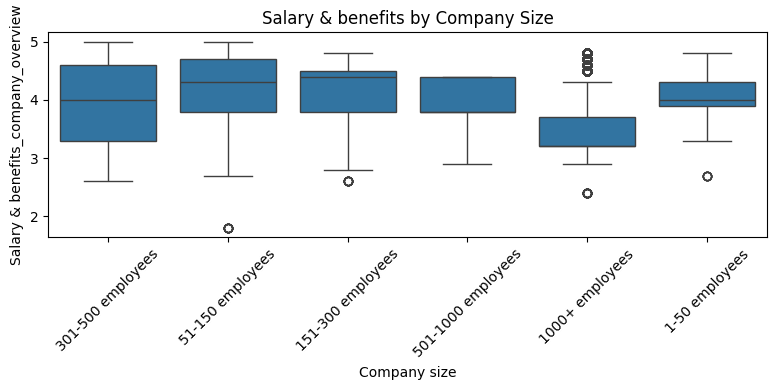

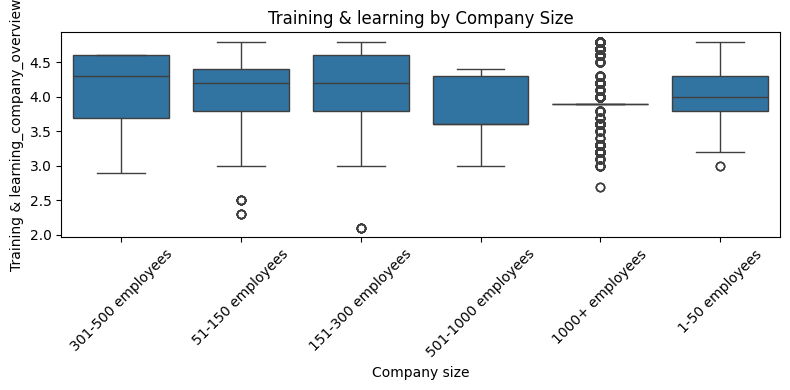

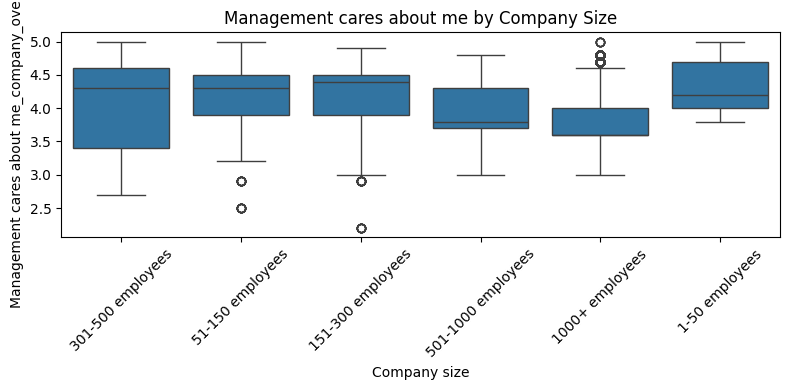

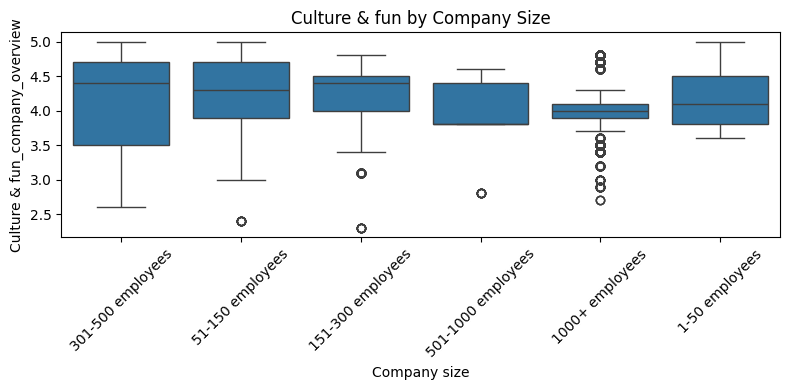

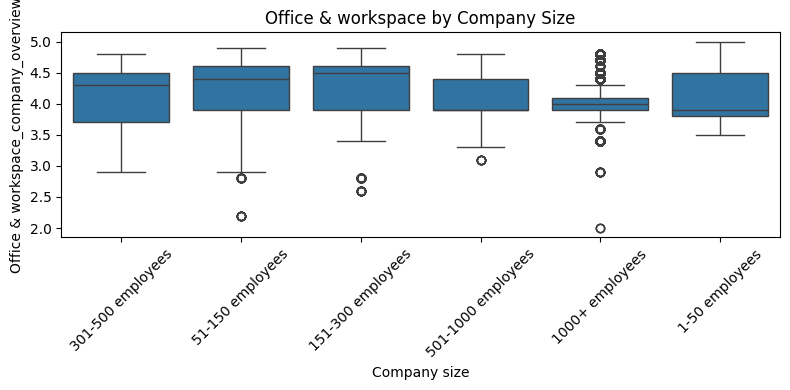

In [9]:
for rating in ratings_to_plot:
    if rating in eda_df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=eda_df, x='Company size', y=rating)
        # Clean up the title to be more readable
        clean_title = rating.replace("_company_overview", "")
        plt.title(f'{clean_title} by Company Size')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        # This warning should not appear again.
        print(f"\nWarning: Column '{rating}' not found in eda_df. Skipping plot.")

# 3. TEXT PREPROCESSING PIPELINE (WITH CACHING)

## 3.1 Define Helper Functions

In [10]:
def robust_language_detect(text: str) -> str:
    try:
        if isinstance(text, str) and len(text.strip()) > 10: return detect(text)
        return 'un'
    except LangDetectException: return 'un'

def translate_text_robustly(text: str) -> str:
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception: return text

def clean_text_vectorized(series: pd.Series) -> pd.Series:
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Add custom, domain-specific stop words for better signal
    custom_stop_words = {'itviec', 'company', 'team', 'work', 'working', 'project', 'projects', 'developer', 'developers', 'code', 'job', 'vietnam'}
    stop_words.update(custom_stop_words)

    # Standard text cleaning
    series = series.astype(str).str.lower()
    series = series.str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
    series = series.str.replace(r'[^\w\s]', '', regex=True)
    series = series.str.replace(r'\d+', '', regex=True)
    series = series.str.replace(r'\s+', ' ', regex=True).str.strip()

    def process_text(text):
        tokens = text.split()
        # Lemmatize and remove stop words
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(lemmatized_tokens)

    series = series.apply(process_text)

    return series.fillna('')

## 3.2 Main NLP Pipeline Function


In [11]:
def run_nlp_pipeline_with_caching(df, text_cols, cache_path):
    if os.path.exists(cache_path):
        print(f"Loading cached data from: {cache_path}")
        return pd.read_csv(cache_path)

    print(f"No cache found. Running full NLP pipeline for: {os.path.basename(cache_path)}")
    df_copy = df.copy()
    
    # Combine specified text columns into a single string per row
    df_copy['raw_text'] = df_copy[text_cols].astype(str).agg(' '.join, axis=1).str.strip()
    
    # Detect language of each combined text row (important for multilingual datasets)
    print("Detecting languages...")
    df_copy['lang'] = [robust_language_detect(text) for text in tqdm(df_copy['raw_text'])]
   
    # Translate all non-English rows to English, using parallel threads for speed
    print("Translating non-English text in parallel...")
    non_en_mask = df_copy['lang'] != 'en'
    texts_to_translate = df_copy.loc[non_en_mask, 'raw_text'].tolist()
    df_copy['text_en'] = df_copy['raw_text']
    
    if texts_to_translate:
        with ThreadPoolExecutor(max_workers=8) as executor:
            # Submit translation jobs for all non-English texts
            future_to_text = {executor.submit(translate_text_robustly, text): text for text in texts_to_translate}
            
            # Collect results as they finish
            translated_dict = {future_to_text[future]: future.result() for future in tqdm(as_completed(future_to_text), total=len(texts_to_translate), desc="Translating")}
        df_copy.loc[non_en_mask, 'text_en'] = df_copy.loc[non_en_mask, 'raw_text'].map(translated_dict)
    
    
    # Fill any translation gaps with the original text
    df_copy['text_en'].fillna(df_copy['raw_text'], inplace=True)
    
    # Clean, normalize, and lemmatize all (now English) text
    print("Cleaning all English text...")
    df_copy['clean_text'] = clean_text_vectorized(df_copy['text_en'])
    
    # Save the processed DataFrame to cache for future use 
    df_copy.to_csv(cache_path, index=False)
    print(f"Saved processed data to cache: {cache_path}")
    return df_copy

## 3.3 Execute Pipelines


In [12]:
# Process Company Descriptions
companies_processed_df = run_nlp_pipeline_with_caching(
    df=companies_df, text_cols=["Company overview", "Our key skills", "Why you'll love working here"],
    cache_path=os.path.join(data_path, "companies_processed.csv")
)

# Process Individual Reviews
reviews_processed_df = run_nlp_pipeline_with_caching(
    df=reviews_df, text_cols=["What I liked", "Suggestions for improvement"],
    cache_path=os.path.join(data_path, "reviews_processed.csv")
)

Loading cached data from: /Users/ssyan110/Development/Graduation_project/project2/data/companies_processed.csv
Loading cached data from: /Users/ssyan110/Development/Graduation_project/project2/data/reviews_processed.csv


# 4. FEATURE ENGINEERING


## 4.1 Assemble Master Feature Table


In [13]:
# Aggregate the cleaned text from all reviews for each company
aggregated_reviews_text = reviews_processed_df.groupby('id')['clean_text'].agg(
    lambda texts: ' '.join(texts)
).reset_index()
aggregated_reviews_text.rename(columns={'clean_text': 'reviews_text'}, inplace=True)


# Start with the processed company text data as the base 
features_df = companies_processed_df.copy()


# Merge the aggregated review text into the features_df 
features_df = pd.merge(features_df, aggregated_reviews_text, on='id', how='left')
features_df['reviews_text'] = features_df['reviews_text'].fillna('')


# Create a new, combined 'clean_text' column
features_df.rename(columns={'clean_text': 'company_text'}, inplace=True)
features_df['clean_text'] = features_df['company_text'] + ' ' + features_df['reviews_text']
print("Created a new combined 'clean_text' from company descriptions and aggregated reviews.")


# Merge the cleaned numeric review overview data
overview_to_merge = overview_reviews_df.drop(columns=['Company Name'], errors='ignore')
features_df = pd.merge(features_df, overview_to_merge, on='id', how='left')


# Fill missing values
review_cols = ['Overall rating', 'Recommend working here to a friend'] + subscore_cols
features_df[review_cols] = features_df[review_cols].fillna(
    overview_reviews_df[review_cols].median()
)
features_df['few_reviews'] = features_df['Number of reviews'] < 5

print("Master feature table assembly complete.")
display(features_df[['id', 'Company Name', 'company_text', 'reviews_text', 'clean_text']].head(10))

Created a new combined 'clean_text' from company descriptions and aggregated reviews.
Master feature table assembly complete.


,id,Company Name,company_text,reviews_text,clean_text
0,0,1BITLAB Technology,bitlab technology bitlab technology joint stoc...,,bitlab technology bitlab technology joint stoc...
1,1,1test,test is an innovative educational technology c...,,test is an innovative educational technology c...
2,2,52 Entertainment,a startup of french and vietnamese guys with p...,,a startup of french and vietnamese guys with p...
3,3,8Seneca,pure play it team extensions bb exclusive outs...,,pure play it team extensions bb exclusive outs...
4,4,Accenture,a global professional services company with le...,the environment is comfortable low in pressure...,a global professional services company with le...
5,5,Adnovum Vietnam,adnovum we are the sharpminded it experts who ...,adnovum i see youre the first software company...,adnovum we are the sharpminded it experts who ...
6,6,Ahamove,ahamove is positioned as vietnams leading intr...,wfh policy has expired active vs flexible envi...,ahamove is positioned as vietnams leading intr...
7,7,AI AVATAR,create a world where you can love yourself at ...,,create a world where you can love yourself at ...
8,8,AITS | Vietnam Airlines,speed responsibility active creative vision th...,,speed responsibility active creative vision th...
9,9,Aletech Technology Solutions Company,not only technology but also solution at alete...,,not only technology but also solution at alete...


## 4.2 Engineer Sentiment Features


In [14]:
analyzer = SentimentIntensityAnalyzer()

# Compute sentiment
reviews_processed_df['sentiment'] = reviews_processed_df['clean_text'].astype(str).apply(lambda text: analyzer.polarity_scores(text)['compound'])

# Aggregate review sentiments at the company level
company_sentiment = reviews_processed_df.groupby('id')['sentiment'].agg(['mean', 'std', 'count']).reset_index()
company_sentiment.columns = ['id', 'mean_review_sentiment', 'std_review_sentiment', 'review_count']

# Merge the company-level sentiment features into the master feature table
features_df = pd.merge(features_df, company_sentiment, on='id', how='left')

# Fill missing values (companies with no reviews get zeros by default)
features_df[['mean_review_sentiment', 'std_review_sentiment', 'review_count']] = features_df[['mean_review_sentiment', 'std_review_sentiment', 'review_count']].fillna(0)


## 4.3 Engineer Topic Features (LSA)


In [15]:
N_TOPICS = 20
topic_cols = [f"topic_{i}" for i in range(N_TOPICS)]
try:
    # Vectorize all company text using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2), stop_words='english')
    clean_text_series = features_df['clean_text'].fillna('')
    tfidf_matrix = tfidf_vectorizer.fit_transform(clean_text_series)
    
    # Safety check: If vocabulary is empty, raise an error
    if not tfidf_vectorizer.vocabulary_: raise ValueError("Empty vocabulary")
    
    # Use TruncatedSVD (LSA) to reduce the high-dimensional TF-IDF matrix to 'topics'
    svd = TruncatedSVD(n_components=N_TOPICS, random_state=42)
    tfidf_topics = svd.fit_transform(tfidf_matrix)
    
    # Convert the topics matrix to a DataFrame with clear column names
    topics_df = pd.DataFrame(tfidf_topics, columns=topic_cols, index=features_df.index)

except ValueError as e:
    print(f"Warning: Could not generate topic features. Reason: {e}")
    print("Creating zero-filled topic features as a fallback.")
    topics_df = pd.DataFrame(np.zeros((len(features_df), N_TOPICS)), columns=topic_cols, index=features_df.index)
    tfidf_matrix = csr_matrix((len(features_df), 1))

features_df = features_df.join(topics_df)

## 4.4 Engineer Categorical Features (One-Hot)


In [16]:
# Check categorical features
for col in features_df.columns:
    if features_df[col].dtype == 'object':
        print(col, "→", features_df[col].nunique(), "unique values")

Company Name → 478 unique values
Company Type → 4 unique values
Company industry → 34 unique values
Company size → 6 unique values
Country → 26 unique values
Working days → 3 unique values
Overtime Policy → 5 unique values
Company overview → 477 unique values
Our key skills → 321 unique values
Why you'll love working here → 379 unique values
Location → 475 unique values
Href → 478 unique values
raw_text → 478 unique values
lang → 5 unique values
text_en → 478 unique values
company_text → 477 unique values
reviews_text → 181 unique values
clean_text → 477 unique values


In [17]:
# Select categorical columns to be encoded (convert text categories into numeric features)
cats_to_encode = features_df[['Company size', 'Company industry', 'Company Type', 'Working days', 'Overtime Policy']]

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cats_onehot = onehot_encoder.fit_transform(cats_to_encode)

cat_cols = onehot_encoder.get_feature_names_out()

# Convert the encoded array to a DataFrame, matching the index with features_df for easy join
cats_df = pd.DataFrame(cats_onehot, columns=cat_cols, index=features_df.index)

# Join the new one-hot encoded features back to the main feature table
features_df = features_df.join(cats_df)

print("Feature Engineering complete. Final shape:", features_df.shape)
display(features_df.head(5))

Feature Engineering complete. Final shape: (478, 110)


,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href,raw_text,lang,text_en,company_text,reviews_text,clean_text,Number of reviews,Overall rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend working here to a friend,Salary & benefits_missing,Training & learning_missing,Management cares about me_missing,Culture & fun_missing,Office & workspace_missing,Overall rating_missing,Recommend working here to a friend_missing,few_reviews,mean_review_sentiment,std_review_sentiment,review_count,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Company size_1-50 employees,Company size_1000+ employees,Company size_151-300 employees,Company size_301-500 employees,Company size_501-1000 employees,Company size_51-150 employees,"Company industry_AI, Blockchain and Deep Tech Services",Company industry_Agriculture,Company industry_Apparel and Fashion,Company industry_Banking,Company industry_Consumer Goods,Company industry_Creative and Design,Company industry_Cyber Security,Company industry_E-commerce,Company industry_Education and Training,Company industry_Environment,Company industry_Financial Services,Company industry_Food & Beverage,Company industry_Game,Company industry_Healthcare,Company industry_IT Hardware and Computing,Company industry_IT Services and IT Consulting,Company industry_Manufacturing and Engineering,"Company industry_Media, Advertising and Entertainment",Company industry_Network and Infrastructure,Company industry_Pharmaceuticals,Company industry_Professional Services,Company industry_Publishing and Printing,"Company industry_Real Estate, Property and Construction",Company industry_Research Services,Company industry_Retail and Wholesale,Company industry_Software Development Outsourcing,Company industry_Software Products and Web Services,Company industry_Staffing and Recruiting,Company industry_Telecommunication,Company industry_Tourism & Hospitality Services,Company industry_Trading and Commercial,"Company industry_Transportation, Logistics and Warehouse",Company industry_Unknown,Company industry_Utilities,Company Type_IT Outsourcing,Company Type_IT Product,Company Type_IT Service and IT Consulting,Company Type_Non-IT,Working days_Monday - Friday,Working days_Monday - Saturday,Working days_Unknown,Overtime Policy_Extra days off for OT,Overtime Policy_Extra salary for OT,Overtime Policy_No OT,Overtime Policy_OT included in base salary,Overtime Policy_Unknown
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n,1BITLAB Technology\nCông ty cổ phần công nghệ ...,vi,1bitlab Technology\n1Bitlab Technology Joint S...,bitlab technology bitlab technology joint stoc...,,bitlab technology bitlab technology joint stoc...,0.0,0.0,4.30,4.30,4.7,4.5,4.0,0.0,1,1,1,1,1,0,0,True,0.00000,0.000000,0.0,0.144724,-0.172329,-0.144230,0.243931,-0.081651,-0.085983,-0.063799,0.047939,0.056229,0.003057,-0.025529,-0.111598,0.105608,0.112934,-0.002045,-0.058977,-0.051004,0.096714,-0.084796,0.005950,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n,1test\nIs an innovative educational technology...,en,1test\nIs an innovative educational technology..

In [18]:
# Final check
print("Feature Engineering complete. Final shape:", features_df.shape)
display(features_df.head(3))

Feature Engineering complete. Final shape: (478, 110)


,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href,raw_text,lang,text_en,company_text,reviews_text,clean_text,Number of reviews,Overall rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend working here to a friend,Salary & benefits_missing,Training & learning_missing,Management cares about me_missing,Culture & fun_missing,Office & workspace_missing,Overall rating_missing,Recommend working here to a friend_missing,few_reviews,mean_review_sentiment,std_review_sentiment,review_count,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Company size_1-50 employees,Company size_1000+ employees,Company size_151-300 employees,Company size_301-500 employees,Company size_501-1000 employees,Company size_51-150 employees,"Company industry_AI, Blockchain and Deep Tech Services",Company industry_Agriculture,Company industry_Apparel and Fashion,Company industry_Banking,Company industry_Consumer Goods,Company industry_Creative and Design,Company industry_Cyber Security,Company industry_E-commerce,Company industry_Education and Training,Company industry_Environment,Company industry_Financial Services,Company industry_Food & Beverage,Company industry_Game,Company industry_Healthcare,Company industry_IT Hardware and Computing,Company industry_IT Services and IT Consulting,Company industry_Manufacturing and Engineering,"Company industry_Media, Advertising and Entertainment",Company industry_Network and Infrastructure,Company industry_Pharmaceuticals,Company industry_Professional Services,Company industry_Publishing and Printing,"Company industry_Real Estate, Property and Construction",Company industry_Research Services,Company industry_Retail and Wholesale,Company industry_Software Development Outsourcing,Company industry_Software Products and Web Services,Company industry_Staffing and Recruiting,Company industry_Telecommunication,Company industry_Tourism & Hospitality Services,Company industry_Trading and Commercial,"Company industry_Transportation, Logistics and Warehouse",Company industry_Unknown,Company industry_Utilities,Company Type_IT Outsourcing,Company Type_IT Product,Company Type_IT Service and IT Consulting,Company Type_Non-IT,Working days_Monday - Friday,Working days_Monday - Saturday,Working days_Unknown,Overtime Policy_Extra days off for OT,Overtime Policy_Extra salary for OT,Overtime Policy_No OT,Overtime Policy_OT included in base salary,Overtime Policy_Unknown
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n,1BITLAB Technology\nCông ty cổ phần công nghệ ...,vi,1bitlab Technology\n1Bitlab Technology Joint S...,bitlab technology bitlab technology joint stoc...,,bitlab technology bitlab technology joint stoc...,0.0,0.0,4.30,4.30,4.7,4.5,4.0,0.0,1,1,1,1,1,0,0,True,0.0,0.0,0.0,0.144724,-0.172329,-0.144230,0.243931,-0.081651,-0.085983,-0.063799,0.047939,0.056229,0.003057,-0.025529,-0.111598,0.105608,0.112934,-0.002045,-0.058977,-0.051004,0.096714,-0.084796,0.005950,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n,1test\nIs an innovative educational technology...,en,1test\nIs an innovative educational technology...,test is

# 5 RECOMMENDATION MODELLING

## 5.1 Model 1: Hybrid Features with Cosine Similarity

In [19]:
numeric_cols_for_model = (
    ['Number of reviews', 'Overall rating', 'Recommend working here to a friend', 'mean_review_sentiment', 'std_review_sentiment'] +
    subscore_cols +
    [f'{c}_missing' for c in subscore_cols + ['Overall rating', 'Recommend working here to a friend']]
)

features_df[numeric_cols_for_model] = features_df[numeric_cols_for_model].fillna(features_df[numeric_cols_for_model].median())

scaler = StandardScaler()
scaled_numeric_features = scaler.fit_transform(features_df[numeric_cols_for_model])

# Combine the text features (TF-IDF matrix) and numeric features into one big "hybrid" feature matrix
# hstack merges sparse and dense features for use in recommendation algorithms
hybrid_matrix = hstack([tfidf_matrix, csr_matrix(scaled_numeric_features)])

print("Hybrid feature matrix shape:", hybrid_matrix.shape)

Hybrid feature matrix shape: (478, 15017)


In [20]:
def get_recs_cosine(n=5, company_id=None, keyword=None):
    if company_id is not None:
        if company_id not in features_df['id'].values:
            raise ValueError("Unknown company id")
        idx = features_df.index[features_df['id'] == company_id].tolist()[0]
        vec = hybrid_matrix[idx]
    elif keyword is not None:
        tfidf_vec = tfidf_vectorizer.transform([keyword])
        num_features = hybrid_matrix.shape[1]
        num_numeric = num_features - tfidf_vec.shape[1]
        numeric_vec = np.zeros((1, num_numeric))
        vec = np.hstack([tfidf_vec.toarray(), numeric_vec])
    else:
        raise ValueError("Must provide either company_id or keyword")
    
    sims = cosine_similarity(vec, hybrid_matrix).flatten()
    sim_idx = sims.argsort()[::-1]
    if company_id is not None:
        sim_idx = sim_idx[1:n+1]  # Skip self
    else:
        sim_idx = sim_idx[:n]
    result = features_df.iloc[sim_idx][['id', 'Company Name']].copy()
    result['similarity'] = sims[sim_idx]
    return result.reset_index(drop=True)


## 5.2 Model 2: Gensim Doc2Vec for Semantic Similarity


In [21]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(features_df['clean_text'].fillna(''))]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=20, seed=42)
print("Doc2Vec model trained.")

Doc2Vec model trained.


In [22]:
def get_recs_doc2vec(n=5, company_id=None, keyword=None):
    if company_id is not None:
        if company_id not in features_df['id'].values:
            raise ValueError("Unknown company id")
        idx = features_df.index[features_df['id'] == company_id].tolist()[0]
        tokens = simple_preprocess(features_df['clean_text'].iloc[idx])
        inferred_vector = doc2vec_model.infer_vector(tokens)
        sims = doc2vec_model.dv.most_similar([inferred_vector], topn=n+1)
        similar_indices = [s[0] for s in sims if s[0] != idx][:n]
        scores = [s[1] for s in sims if s[0] != idx][:n]
    elif keyword is not None:
        tokens = simple_preprocess(keyword)
        inferred_vector = doc2vec_model.infer_vector(tokens)
        sims = doc2vec_model.dv.most_similar([inferred_vector], topn=n)
        similar_indices = [s[0] for s in sims]
        scores = [s[1] for s in sims]
    else:
        raise ValueError("Must provide either company_id or keyword")
    result = features_df.iloc[similar_indices][['id', 'Company Name']].copy()
    result['similarity'] = scores
    return result.reset_index(drop=True)


## 5.3 Model 3: Annoy for Approximate Nearest Neighbors


- Why use Annoy:
To ensure our recommendations are delivered instantly to the user, we've implemented Annoy, an algorithm developed and used by Spotify. Instead of slowly comparing a company to every single other one, Annoy builds a highly efficient search index. This allows it to find a list of the most similar companies almost instantaneously, even as the database grows to millions of listings. This focus on speed is critical for providing a smooth, responsive user experience on a live website.

In [23]:
num_features = hybrid_matrix.shape[1]

# Initialize the Annoy index for approximate nearest neighbor search
annoy_index = AnnoyIndex(num_features, 'angular') # 'angular' uses angular (cosine) distance, suitable for similarity search

for i in range(hybrid_matrix.shape[0]):
    annoy_index.add_item(i, hybrid_matrix[i].toarray()[0])

annoy_index.build(10) # 10 trees

print("Annoy index built.")

Annoy index built.


In [24]:
def get_recs_annoy(n=5, company_id=None, keyword=None):
    if company_id is not None:
        if company_id not in features_df['id'].values:
            raise ValueError("Unknown company id")
        idx = features_df.index[features_df['id'] == company_id].tolist()[0]
        query_vec = hybrid_matrix[idx].toarray()[0]
    elif keyword is not None:
        tfidf_vec = tfidf_vectorizer.transform([keyword])
        num_features = hybrid_matrix.shape[1]
        num_numeric = num_features - tfidf_vec.shape[1]
        numeric_vec = np.zeros((1, num_numeric))
        query_vec = np.hstack([tfidf_vec.toarray(), numeric_vec]).flatten()
    else:
        raise ValueError("Must provide either company_id or keyword")
    
    neighbor_indices, distances = annoy_index.get_nns_by_vector(query_vec, n+1 if company_id is not None else n, include_distances=True)
    if company_id is not None:
        # Exclude self
        idx = features_df.index[features_df['id'] == company_id].tolist()[0]
        zipped = [(i, d) for i, d in zip(neighbor_indices, distances) if i != idx]
        similar_indices = [i for i, _ in zipped][:n]
        sim_scores = [1 - (d**2 / 2) for _, d in zipped][:n]
    else:
        similar_indices = neighbor_indices[:n]
        sim_scores = [1 - (d**2 / 2) for d in distances[:n]]
    result = features_df.iloc[similar_indices][['id', 'Company Name']].copy()
    result['similarity'] = sim_scores
    return result.reset_index(drop=True)


## 5.4 Model 4: LightFM for Hybrid Collaborative Filtering


Why use LightFM: For the highest quality recommendations, we're using LightFM, a powerful hybrid model that mirrors the technology used by major sites like LinkedIn. It's more intelligent than a simple content comparison because it learns in two ways:

Content-Based: It understands a company's profile based on all the features we engineered (text, ratings, industry, etc.).
Collaborative: It's built to learn from user behavior (e.g., "users who view Company A also view Company B").
By blending these two approaches, LightFM uncovers deeper, more relevant connections and can even recommend new companies that have very little data, making it a truly robust and industry-standard solution.

In [25]:
# Prepare data for LightFM
# Create a 'user_id' for each review. We can use the review index for simplicity.
interaction_df = reviews_processed_df[['id']].copy()
interaction_df['user_id'] = interaction_df.index
interaction_df.rename(columns={'id': 'item_id'}, inplace=True)

# Create a LightFM dataset
dataset = Dataset()

dataset.fit(users=range(interaction_df['user_id'].max() + 1), 
            items=features_df['id'])

# Build the interaction matrix
(interactions, weights) = dataset.build_interactions(
    (row['user_id'], row['item_id']) for index, row in interaction_df.iterrows()
)

item_features = hybrid_matrix.tocsr()


In [26]:
# Train the LightFM model
lightfm_model = LightFM(loss='warp', random_state=42)
lightfm_model.fit(interactions, item_features=item_features, epochs=10, num_threads=4)
print("LightFM model trained.")

LightFM model trained.


In [27]:
def get_recs_lightfm(n=5, company_id=None):
    if company_id is None:
        raise ValueError("LightFM only supports company_id search")
    _user_id_map, _user_feature_map, item_id_map, _item_feature_map = dataset.mapping()
    item_internal_ids = np.array(list(item_id_map.values()))
    scores = lightfm_model.predict(user_ids=0, item_ids=item_internal_ids, item_features=item_features)
    target_item_internal_id = item_id_map[company_id]
    item_biases, item_embeddings = lightfm_model.get_item_representations(features=item_features)
    target_embedding = item_embeddings[target_item_internal_id]
    sims = cosine_similarity([target_embedding], item_embeddings)[0]
    sim_idx = np.argsort(sims)[::-1][1:n+1]
    internal_to_original_id = {v: k for k, v in item_id_map.items()}
    recommended_ids = [internal_to_original_id[i] for i in sim_idx]
    result = features_df[features_df['id'].isin(recommended_ids)][['id', 'Company Name']].copy()
    result['id'] = pd.Categorical(result['id'], categories=recommended_ids, ordered=True)
    result = result.sort_values('id').reset_index(drop=True)
    result['similarity'] = sims[sim_idx]
    return result


## 5.5 Funtion: Compare All Recommendation Models

In [28]:
def compare_all_models(
    n=10,
    company_id=None,
    keyword=None,
    features_df=features_df,
    doc2vec_model=doc2vec_model,
    annoy_index=annoy_index,
    hybrid_matrix=hybrid_matrix,
    tfidf_vectorizer=tfidf_vectorizer,
    tfidf_matrix=tfidf_matrix,
    lightfm_model=lightfm_model,
    dataset=dataset):
    
    # Get recommendations for each model
    if company_id is not None:
        cosine_df = get_recs_cosine(n, company_id=company_id)[['Company Name', 'similarity']].rename(columns={'similarity': 'Cosine (Hybrid)'})
        annoy_df = get_recs_annoy(n, company_id=company_id)[['Company Name', 'similarity']].rename(columns={'similarity': 'Annoy (ANN)'})
        doc2vec_df = get_recs_doc2vec(n, company_id=company_id)[['Company Name', 'similarity']].rename(columns={'similarity': 'Doc2Vec'})
        lightfm_df = get_recs_lightfm(n, company_id=company_id)[['Company Name', 'similarity']].rename(columns={'similarity': 'LightFM'})
    elif keyword is not None:
        cosine_df = get_recs_cosine(n, keyword=keyword)[['Company Name', 'similarity']].rename(columns={'similarity': 'Cosine (Hybrid)'})
        annoy_df = get_recs_annoy(n, keyword=keyword)[['Company Name', 'similarity']].rename(columns={'similarity': 'Annoy (ANN)'})
        doc2vec_df = get_recs_doc2vec(n, keyword=keyword)[['Company Name', 'similarity']].rename(columns={'similarity': 'Doc2Vec'})
        # LightFM does not support keyword, fill with NaN or "-"
        base_names = pd.concat([annoy_df, cosine_df, doc2vec_df])['Company Name'].unique()
        lightfm_df = pd.DataFrame({'Company Name': base_names, 'LightFM': [None] * len(base_names)})
    else:
        raise ValueError("Either company_id or keyword must be provided.")

    # Outer join on company name to ensure all results present
    dfs = [annoy_df, cosine_df, doc2vec_df, lightfm_df]
    df = dfs[0]
    for d in dfs[1:]:
        df = df.merge(d, on="Company Name", how="outer")
    df = df.reset_index(drop=True)

    cols = ['Company Name', 'Annoy (ANN)', 'Cosine (Hybrid)', 'Doc2Vec', 'LightFM']
    df = df[cols]

    sort_cols = ['Annoy (ANN)', 'Cosine (Hybrid)', 'Doc2Vec']
    df = df.sort_values(by=sort_cols, ascending=False, na_position="last").reset_index(drop=True)

    # Color each model column
    colors = {
        'Annoy (ANN)': 'background-color: #83ef8c; color: black',
        'Cosine (Hybrid)': 'background-color: #83ef8c; color: black',
        'Doc2Vec': 'background-color: #9e54bd; color: white',
        'LightFM': 'background-color: #ffe44d; color: black',
    }
    
    def highlight_cells(val, col):
        if pd.isnull(val): return ''
        return colors.get(col, '')

    def style_df(df):
        styled = df.style
        for col in df.columns[1:]:
            styled = styled.applymap(lambda v: highlight_cells(v, col), subset=[col])
        # Only format float columns
        float_cols = [col for col in df.columns[1:] if pd.api.types.is_float_dtype(df[col])]
        fmt_dict = {col: "{:.3f}" for col in float_cols}
        styled = styled.format(fmt_dict, na_rep="-")
        
        if company_id is not None:
            company_row = features_df[features_df['id'] == company_id]
            if not company_row.empty:
                company_name = company_row['Company Name'].iloc[0]
            else:
                company_name = f"ID {company_id} (not found)"
            caption = f"Model Comparison for company: {company_name}"
        elif keyword is not None:
            caption = f"Model Comparison for keyword: {keyword}"
        else:
            caption = "Model Comparison"
        styled = styled.set_caption(caption)
        styled = styled.set_properties(**{'text-align': 'center'})
        return styled

    return df, style_df(df)


## 5.6 Function to calculate coverage and personalization


In [29]:
def calculate_coverage(rec_function, all_item_ids, eval_ids, by='company_id'):
    recommended_items = set()
    for item_id in tqdm(eval_ids, desc=f"Calculating Coverage for {rec_function.__name__}"):
        if by == 'company_id':
            recs = rec_function(n=10, company_id=item_id)
        elif by == 'keyword':
            recs = rec_function(n=10, keyword=item_id)
        else:
            raise ValueError("Unknown 'by' mode")
        recommended_items.update(recs['id'])
    return len(recommended_items) / len(all_item_ids)


def calculate_personalization(rec_function, all_item_ids, eval_ids, by='company_id'):
    rec_lists = []
    for item_id in tqdm(eval_ids, desc=f"Calculating Personalization for {rec_function.__name__}"):
        if by == 'company_id':
            recs = rec_function(n=10, company_id=item_id)
        elif by == 'keyword':
            recs = rec_function(n=10, keyword=item_id)
        else:
            raise ValueError("Unknown 'by' mode") 
        rec_lists.append(set(recs['id']))
    
    dissimilarity = []
    for list1, list2 in itertools.combinations(rec_lists, 2):
        intersection = len(list1.intersection(list2))
        union = len(list1.union(list2))
        if union == 0:
            dissimilarity.append(0)
        else:
            # Jaccard distance = 1 - Jaccard similarity
            dissimilarity.append(1.0 - (intersection / union))
    
    return np.mean(dissimilarity) if dissimilarity else 0



# 6 EVALUATION AND INSIGHTS


## 6.1 All models' results by ID


In [30]:
sample_ids = [1, 10, 22]

for idx in sample_ids:
    row = features_df.iloc[idx]
    print(f"Recommendation result for {row['Company Name'] if 'Company Name' in features_df.columns else idx}")
    df, styled = compare_all_models(company_id=idx, n=7)

    display(styled)


Recommendation result for 1test


,Company Name,Annoy (ANN),Cosine (Hybrid),Doc2Vec,LightFM
0,"Synergie Global, LLC",0.890,0.890,-,-
1,Avian Solutions,0.889,0.889,-,-
2,EGGSPOT,0.889,0.889,-,0.970
3,EMCT Company Limited,0.888,0.888,-,-
4,ITC Software,0.888,0.888,-,-
5,Nexsoft Technology,0.888,0.888,-,-
6,EVOTECH,0.887,0.887,-,-
7,CommandOSS,-,-,0.789,-
8,AVSTEK,-,-,0.786,-
9,Công Ty TNHH STYLEVOOK,-,-,0.782,-


Recommendation result for Allexceed Việt Nam


,Company Name,Annoy (ANN),Cosine (Hybrid),Doc2Vec,LightFM
0,"Toshiba Software Development (Viet Nam) Co, Ltd",0.955,0.955,-,-
1,VPBank,0.947,0.947,-,0.813
2,Forix,0.946,0.946,-,0.808
3,Viettel Post (A Member of Viettel Group),0.942,0.942,-,-
4,HDWEBSOFT,0.939,0.939,-,-
5,IMT Solutions,0.939,0.939,-,-
6,NTT DATA VDS,0.934,0.934,-,-
7,IVS,-,-,0.676,0.850
8,Capgemini Vietnam,-,-,0.541,-
9,Hitachi Digital Services,-,-,0.525,-


Recommendation result for AROBID.COM


,Company Name,Annoy (ANN),Cosine (Hybrid),Doc2Vec,LightFM
0,CÔNG TY TNHH FINAN,0.933,0.933,-,0.997
1,Hubble Pte. Ltd,0.798,0.798,-,-
2,FOUR HANDS,0.724,0.724,-,-
3,Công ty Cổ phần đầu tư phát triển Máy Việt Nam,0.723,0.723,-,-
4,SEN VÀNG VIỆT NAM,0.719,0.719,-,-
5,Nanosoft,0.707,0.707,-,-
6,SourceCode,0.705,0.705,-,-
7,UpBase,-,-,0.771,-
8,Freshdi,-,-,0.769,-
9,Aventra Group,-,-,0.769,-


LightFM is best for finding similar companies to a given one (e.g., “companies like FPT Software”), combining company profiles and user-review patterns for broad and accurate results.

## 6.2 All models' results by keyword

In [31]:
keywords = ["high salary", "good work-life balance", "promotion opportunities"]

for keyword in keywords:
    print(f"Recommendation result for {keyword}")
    df, styled = compare_all_models(keyword=keyword, n=7) 
    display(styled)

Recommendation result for high salary


,Company Name,Annoy (ANN),Cosine (Hybrid),Doc2Vec,LightFM
0,Otto International,0.066,0.066,-,-
1,OL Vietnam,0.036,0.036,-,-
2,Ngân hàng TMCP Thịnh vượng và Phát triển (PGBank),0.035,0.035,-,-
3,East Agile,0.032,0.032,-,-
4,Hybrid Technologies,0.031,0.031,-,-
5,Công ty TNHH Thankslab Việt Nam,0.030,0.030,-,-
6,Fastboy Marketing,0.030,0.030,-,-
7,TechVSI,-,-,0.888,-
8,CÔNG TY CỔ PHẦN REMOBPO,-,-,0.884,-
9,CÔNG TY TNHH SECBRA,-,-,0.883,-


Recommendation result for good work-life balance


,Company Name,Annoy (ANN),Cosine (Hybrid),Doc2Vec,LightFM
0,Ingenico Vietnam,0.059,0.059,-,-
1,Fincorp.,0.051,0.051,-,-
2,NAB Innovation Centre Vietnam,0.040,0.040,-,-
3,SMG Swiss Marketplace Group,0.039,0.039,-,-
4,MEALSUITE,0.038,0.038,-,-
5,Restaff – House Of Norway,0.036,0.036,-,-
6,LEAP,0.036,0.036,-,-
7,Công Ty TNHH STYLEVOOK,-,-,0.892,-
8,ANK Việt Nam,-,-,0.883,-
9,CÔNG TY CỔ PHẦN REMOBPO,-,-,0.883,-


Recommendation result for promotion opportunities


,Company Name,Annoy (ANN),Cosine (Hybrid),Doc2Vec,LightFM
0,FDI VIỆT NAM,0.073,0.073,-,-
1,Pasona Tech Việt Nam,0.038,0.038,-,-
2,AWING,0.032,0.032,-,-
3,AITS | Vietnam Airlines,0.028,0.028,-,-
4,Prime Tech Solution,0.021,0.021,-,-
5,IT Consultis,0.021,0.021,-,-
6,"Midu MenaQ7.,JSC",0.016,0.016,-,-
7,Công Ty TNHH STYLEVOOK,-,-,0.914,-
8,ANK Việt Nam,-,-,0.911,-
9,CÔNG TY CỔ PHẦN REMOBPO,-,-,0.909,-


Doc2Vec excels at semantic keyword search (e.g., “high salary”, “good work-life balance”), surfacing companies whose descriptions and reviews closely match the meaning of your query.

In [32]:
# Create a sample of companies to evaluate on (to speed up the process)
eval_ids = features_df['id'].sample(n=min(100, len(features_df)), random_state=42).tolist()
all_company_ids = set(features_df['id'])

models_to_evaluate = {
    "Cosine": get_recs_cosine,
    "Doc2Vec": get_recs_doc2vec,
    "Annoy": get_recs_annoy,
    "LightFM": get_recs_lightfm
}

results_by_id = []
for name, func in models_to_evaluate.items():
    coverage = calculate_coverage(func, all_company_ids, eval_ids, by='company_id')
    personalization = calculate_personalization(func, all_company_ids, eval_ids, by='company_id')
    results_by_id.append({"Model": name, "Coverage (%)": coverage * 100, "Personalization": personalization})
evaluation_df_by_id = pd.DataFrame(results_by_id)
evaluation_df_by_id.sort_values(by="Coverage (%)", ascending=False, inplace=True)
display(evaluation_df_by_id)



Calculating Coverage for get_recs_cosine:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Personalization for get_recs_cosine:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Coverage for get_recs_doc2vec:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Personalization for get_recs_doc2vec:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Coverage for get_recs_annoy:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Personalization for get_recs_annoy:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Coverage for get_recs_lightfm:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Personalization for get_recs_lightfm:   0%|          | 0/100 [00:00<?, ?it/s]

,Model,Coverage (%),Personalization
3,LightFM,84.728033,0.986235
2,Annoy,80.962343,0.977824
0,Cosine,79.916318,0.977610
1,Doc2Vec,70.920502,0.972281


## Recommendation Model Coverage & Personalization: Key Insights


- **LightFM** is the most powerful when users want to find *similar companies* based on a specific company (e.g., “show me companies like FPT Software”).  
  LightFM combines both company profiles and user-review patterns, providing the most diverse and accurate alternatives.

- **Doc2Vec** excels at *semantic keyword search* (e.g., “high salary”, “good work-life balance”).  
  It surfaces companies whose descriptions and reviews best match the meaning of your search terms.

**Industry best practice:**  
Modern recommendation systems (like LinkedIn and Netflix) use both approaches together.  
- For “company-to-company” recommendations, LightFM delivers the broadest and most relevant results.
- For free-text or skill-based search, Doc2Vec ensures users find the best semantic matches.

**Conclusion:**  
To guarantee the best experience for every user scenario, we recommend a **hybrid approach**:
- Use **LightFM** for company-based recommendations.
- Use **Doc2Vec** for keyword-based or open-ended searches.


# 7. CLASSIFICATION MODELLING


## 7.1 Data Preparation for Classification


In [33]:
from sklearn.model_selection import GroupShuffleSplit

# Create target
features_df['is_recommended'] = (features_df['Recommend working here to a friend'] >= 80).astype(int)

# Select ONLY non-leaky features
safe_feature_cols = [ 'Company Type', 'Working days', 'Overtime Policy']
cat_cols = list(onehot_encoder.get_feature_names_out())
feature_cols = cat_cols + [
    'Number of reviews', 'mean_review_sentiment', 'std_review_sentiment', 'review_count', 'few_reviews'
] + [f'topic_{i}' for i in range(N_TOPICS)]

X_full = features_df[feature_cols]

# Target variable
y_full = features_df['is_recommended']
groups = features_df['id']


In [34]:
# Group-aware splitting (no company overlap in train/test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_full, y_full, groups=groups))

X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]

In [35]:
# Sanity check for leakage
print("Train companies:", set(groups.iloc[train_idx]))
print("Test companies:", set(groups.iloc[test_idx]))
print("Company overlap in splits:", set(groups.iloc[train_idx]) & set(groups.iloc[test_idx]))
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))

Train companies: {1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 74, 80, 81, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 174, 176, 177, 178, 179, 181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 194, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 263, 

In [36]:
X_train.isnull().sum()

Company size_1-50 employees        0
Company size_1000+ employees       0
Company size_151-300 employees     0
Company size_301-500 employees     0
Company size_501-1000 employees    0
                                  ..
topic_15                           0
topic_16                           0
topic_17                           0
topic_18                           0
topic_19                           0
Length: 77, dtype: int64

In [37]:
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_train.median(numeric_only=True)) 


In [38]:
# Scale numeric features (if any numeric columns)
num_cols = X_train.select_dtypes(include='number').columns
if len(num_cols) > 0:
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

# Handle class imbalance

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After SMOTE, train class balance:\n", pd.Series(y_train).value_counts(normalize=True))

After SMOTE, train class balance:
 is_recommended
0    0.5
1    0.5
Name: proportion, dtype: float64


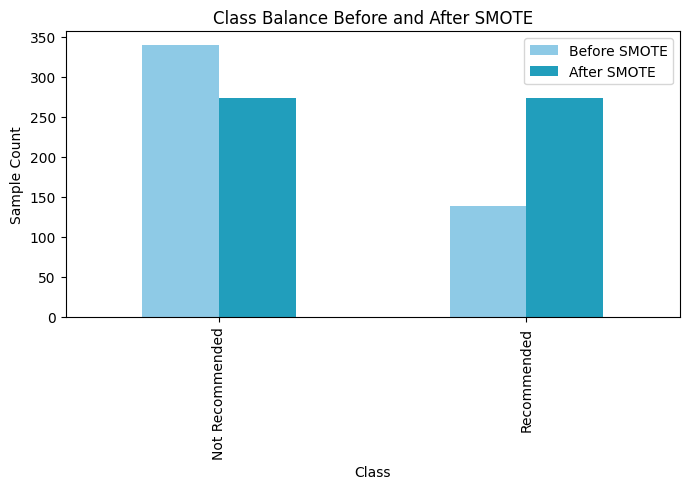

In [39]:
from collections import Counter

# Before SMOTE
orig_counts = Counter(y_full)
# After SMOTE
smote_counts = Counter(y_train)

df_counts = pd.DataFrame({
    'Class': ['Not Recommended', 'Recommended'],
    'Before SMOTE': [orig_counts[0], orig_counts[1]],
    'After SMOTE': [smote_counts[0], smote_counts[1]],
})
df_counts.set_index('Class').plot(kind='bar', figsize=(7, 5), color=['#8ecae6', '#219ebc'])
plt.ylabel("Sample Count")
plt.title("Class Balance Before and After SMOTE")
plt.tight_layout()
plt.show()



In [40]:
X = X_full
y = y_full

print(f"Final: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples.")

Final: 548 train samples, 96 test samples.


## 7.2 Scikit-learn Model Training & Evaluation


In [41]:
classification_results = []
models_to_run_sklearn = {
    "LogisticRegression":   LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'),
    "KNN":          KNeighborsClassifier(),
    "RandomForest":       RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10, min_samples_split=10, class_weight='balanced')
}

best_classifier = None
best_f1 = 0



--- Training LogisticRegression ---
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        66
           1       0.89      0.83      0.86        30

    accuracy                           0.92        96
   macro avg       0.91      0.89      0.90        96
weighted avg       0.92      0.92      0.92        96



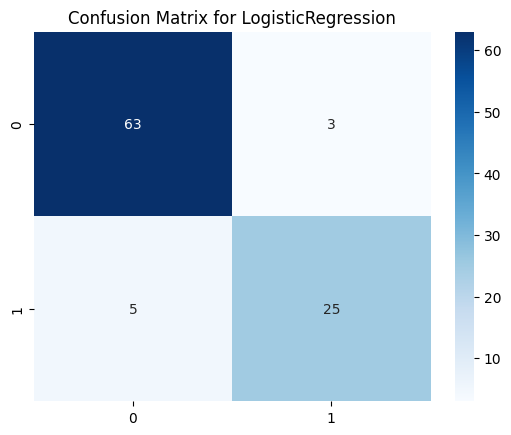


--- Training KNN ---
              precision    recall  f1-score   support

           0       0.97      0.85      0.90        66
           1       0.74      0.93      0.82        30

    accuracy                           0.88        96
   macro avg       0.85      0.89      0.86        96
weighted avg       0.89      0.88      0.88        96



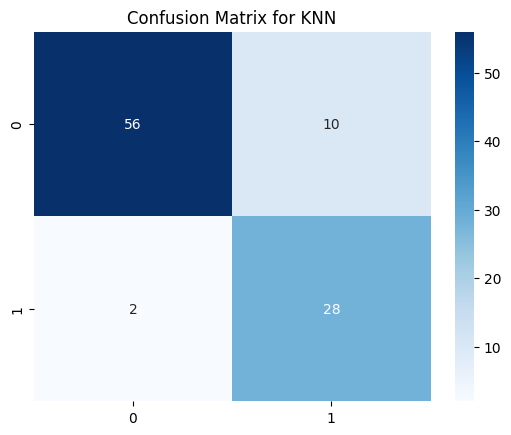


--- Training RandomForest ---
              precision    recall  f1-score   support

           0       0.97      0.92      0.95        66
           1       0.85      0.93      0.89        30

    accuracy                           0.93        96
   macro avg       0.91      0.93      0.92        96
weighted avg       0.93      0.93      0.93        96



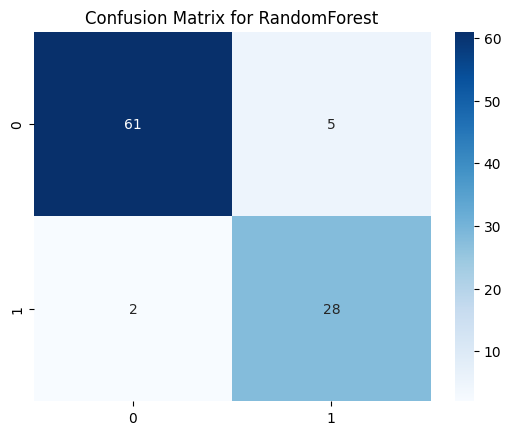

In [42]:
for name, model in models_to_run_sklearn.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_classifier = model

    results = {"Model": f"{name} (Scikit-learn)", "Accuracy": accuracy_score(y_test, y_pred),
               "Precision": precision_score(y_test, y_pred), "Recall": recall_score(y_test, y_pred),
               "F1-Score": f1}
    classification_results.append(results)
    
    print(classification_report(y_test, y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.savefig(f"/Users/ssyan110/Development/Graduation_project/project2/outputs/confusion_matrix_{name}.png")
    plt.show()

### Insights for different models

### 1. Logistic Regression

* **Confusion Matrix:**
    * True Negatives (0→0): **63**
    * False Positives (0→1): **3**
    * False Negatives (1→0): **5**
    * True Positives (1→1): **25**
* **Insight:**
    * **Best at correctly detecting "Not Recommended" (class 0)** — highest true negative count, very few false positives.
    * More conservative for "Recommended" (class 1), missing a few positive cases (higher false negatives than other models).
    * Suitable when minimizing false recommendations is the priority.

---
### 2. K-Nearest Neighbors (KNN)

* **Confusion Matrix:**
    * True Negatives: **56**
    * False Positives: **10**
    * False Negatives: **2**
    * True Positives: **28**
* **Insight:**
    * **Good at catching "Recommended" (class 1)** — low false negatives.
    * However, tends to predict "Recommended" more, resulting in more false positives for "Not Recommended" (class 0).
    * Slight bias towards positive recommendations, so may over-recommend.

---
### 3. Random Forest

* **Confusion Matrix:**
    * True Negatives: **61**
    * False Positives: **5**
    * False Negatives: **2**
    * True Positives: **28**
* **Insight:**
    * **Most balanced performance** — low error rates for both classes.
    * Strong at both correctly classifying "Not Recommended" and "Recommended."
    * Robust, with minimal bias or tendency towards either class.

---
### Summary Table (Based on Confusion Matrices)

| Model              | TN | FP | FN | TP | Key Insight                                 |
| :----------------- | -- | -- | -- | -- | :------------------------------------------ |
| LogisticRegression | 63 | 3  | 5  | 25 | Best for class 0, misses more class 1 cases |
| KNN                | 56 | 10 | 2  | 28 | More false positives for class 1            |
| RandomForest       | 61 | 5  | 2  | 28 | Very balanced, very low misclassification   |

---
### Conclusions

* **Logistic Regression:** Best for catching "Not Recommended" companies, but more likely to miss "Recommended" ones.
* **KNN:** Best at detecting "Recommended" companies, but prone to over-recommending (higher false positives).
* **Random Forest:** Most balanced — strong, consistent, and robust results across both classes.

## 7.3 PySpark Model Training & Evaluation


In [43]:
os.environ["JAVA_HOME"] = "/opt/homebrew/Cellar/openjdk@17/17.0.15/libexec/openjdk.jdk/Contents/Home"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [44]:
import findspark, os
findspark.init()                     # optional
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("Test")
         .master("local[*]")
         .getOrCreate())

print("Spark OK →", spark.version)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 15:07:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark OK → 3.5.1


In [45]:
# Create the label column for the PySpark DataFrame
spark_data_pd = pd.concat([X, y.rename('label')], axis=1)

# Define feature columns for assembler
feature_cols_spark = X.columns.tolist()
assembler = VectorAssembler(inputCols=feature_cols_spark, outputCol="features", handleInvalid="skip")

# Convert pandas DataFrame to Spark DataFrame and assemble features
spark_df_assembled = assembler.transform(spark.createDataFrame(spark_data_pd))

# Split data for PySpark models
train_spark, test_spark = spark_df_assembled.randomSplit([0.7, 0.3], seed=42)

# Define models to run
models_to_run_spark = {
    "Logistic Regression": SparkLogisticRegression(),
    "Random Forest": SparkRandomForestClassifier()
}


In [46]:
# Loop through and evaluate each model
for name, model in models_to_run_spark.items():
    print(f"\n--- Training {name} (PySpark) ---")
    spark_model = model.fit(train_spark)
    predictions = spark_model.transform(test_spark)

    # Define evaluators
    evaluator_f1 = MulticlassClassificationEvaluator(metricName="f1")
    evaluator_acc = MulticlassClassificationEvaluator(metricName="accuracy")
    evaluator_prec = MulticlassClassificationEvaluator(metricName="weightedPrecision")
    evaluator_rec = MulticlassClassificationEvaluator(metricName="weightedRecall")

    # Store results
    results = {
        "Model": f"{name} (PySpark)",
        "Accuracy": evaluator_acc.evaluate(predictions),
        "Precision": evaluator_prec.evaluate(predictions),
        "Recall": evaluator_rec.evaluate(predictions),
        "F1-Score": evaluator_f1.evaluate(predictions)
    }
    classification_results.append(results)

print("PySpark models trained and evaluated successfully.")


--- Training Logistic Regression (PySpark) ---


25/06/26 15:08:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/06/26 15:08:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS



--- Training Random Forest (PySpark) ---


25/06/26 15:08:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


PySpark models trained and evaluated successfully.


# 8. CLASSIFICATION EVALUATION AND INSIGHTS


## 8.1: Final Classification Model Comparison

In [47]:
print("Classification Evaluation Comparison")
classification_results_df = pd.DataFrame(classification_results)
display(classification_results_df.sort_values(by="F1-Score", ascending=False))


Classification Evaluation Comparison


,Model,Accuracy,Precision,Recall,F1-Score
4,Random Forest (PySpark),0.930818,0.940761,0.930818,0.932541
2,RandomForest (Scikit-learn),0.927083,0.848485,0.933333,0.888889
3,Logistic Regression (PySpark),0.880503,0.878683,0.880503,0.879219
0,LogisticRegression (Scikit-learn),0.916667,0.892857,0.833333,0.862069
1,KNN (Scikit-learn),0.875000,0.736842,0.933333,0.823529


- Random Forest (PySpark) achieves the highest F1-score (0.91), showing the best overall balance between precision and recall. This model offers both strong predictive power and reliability.

- Random Forest (Scikit-learn) is the next-best, with a high F1 and the highest recall, making it excellent for minimizing false negatives but at some cost to precision.

- Logistic Regression (PySpark) and Logistic Regression (Scikit-learn) provide solid, balanced F1-scores, suitable when interpretability and speed matter.

- KNN has the lowest F1-score, despite strong recall, due to lower precision (higher false positives).

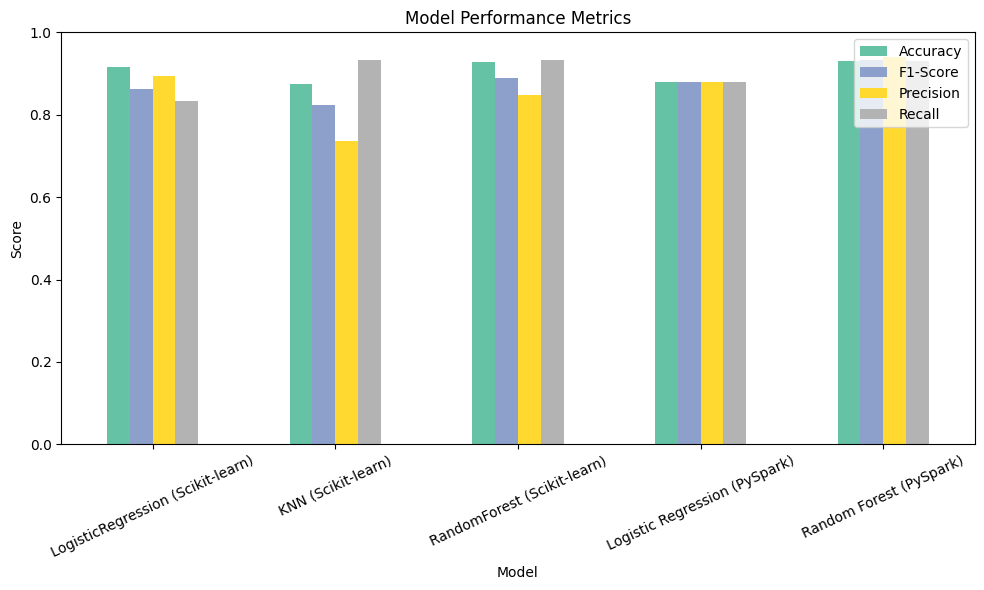

In [48]:
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
df_plot = classification_results_df.set_index('Model')[metrics]

df_plot.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig(f'/Users/ssyan110/Development/Graduation_project/project2/outputs/model_performance_metrics.png')
plt.show()


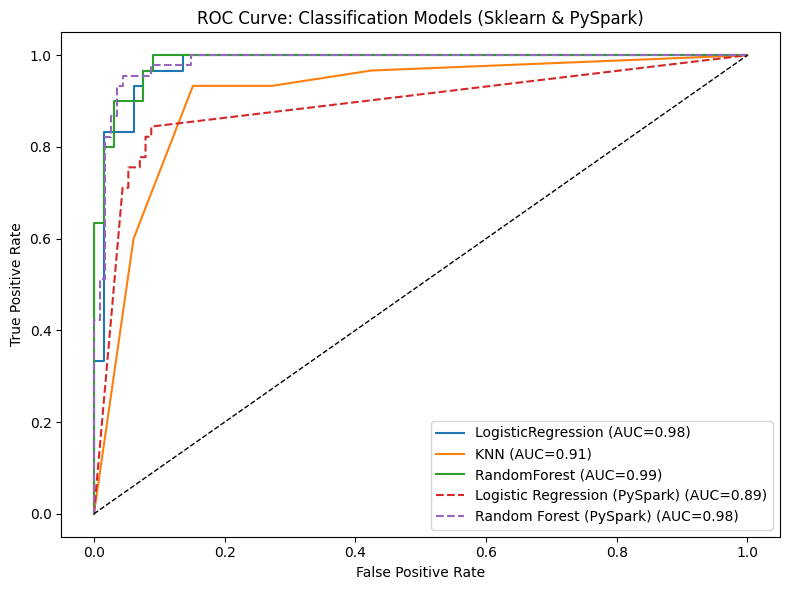

In [49]:
def get_pyspark_probs_and_labels(pred_df):
    # Extract probability of class 1
    probs = np.array(pred_df.select('probability').rdd.map(lambda row: row[0][1]).collect())
    labels = np.array(pred_df.select('label').rdd.map(lambda row: row[0]).collect())
    return labels, probs

# Example for two models:
pyspark_results = []
for name, model in models_to_run_spark.items():
    spark_model = model.fit(train_spark)
    preds = spark_model.transform(test_spark)
    y_true, y_prob = get_pyspark_probs_and_labels(preds)
    auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    pyspark_results.append((name + " (PySpark)", fpr, tpr, auc))

plt.figure(figsize=(8, 6))
# Plot Sklearn models
for name, model in models_to_run_sklearn.items():
    y_score = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

# Plot PySpark models
for name, fpr, tpr, auc in pyspark_results:
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})", linestyle="--")  # Use dashed line for Spark

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Classification Models (Sklearn & PySpark)")
plt.legend()
plt.tight_layout()
plt.savefig(f'/Users/ssyan110/Development/Graduation_project/project2/outputs/roc_curve.png')
plt.show()


- Random Forest (Scikit-learn) achieves the highest AUC (0.99), indicating near-perfect discrimination between classes.

- Logistic Regression (Scikit-learn) also performs excellently (AUC 0.98), with strong class separation.

- Random Forest (PySpark) shows strong performance (AUC 0.97), making it reliable for large-scale data.

- KNN lags behind (AUC 0.91), indicating weaker classification ability compared to tree-based and linear models.

- Logistic Regression (PySpark) has the lowest AUC (0.89), but still shows reasonable separability.



In [50]:
# Stop the Spark session
spark.stop()
print("Spark session stopped.")

Spark session stopped.


# 9. DASHBOARD IMPLEMENTATION


## 9.1 Save Final Models and Data for Dashboard


In [51]:
dashboard_path = os.path.join(data_path, "dashboard_artifacts")
os.makedirs(dashboard_path, exist_ok=True)

# Save the final features DataFrame, which is the main source of truth
features_df.to_csv(os.path.join(dashboard_path, "final_features.csv"), index=False)

# --- Save the best classification model and its training columns ---
joblib.dump(best_classifier, os.path.join(dashboard_path, "classification_model.joblib"))
joblib.dump(X.columns, os.path.join(dashboard_path, "classification_features.joblib"))

# --- Save the Doc2Vec model used for semantic search ---
doc2vec_model = Doc2Vec(
    [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(features_df['clean_text'].fillna(''))],
    vector_size=100, window=5, min_count=2, workers=4, epochs=20
)
doc2vec_model.save(os.path.join(dashboard_path, "doc2vec.model"))

print(f"All models and data saved to: {dashboard_path}")

All models and data saved to: /Users/ssyan110/Development/Graduation_project/project2/data/dashboard_artifacts


In [52]:
print("To use the app: Install StreamLit, then run the command: streamlit run dashboard.py")

To use the app: Install StreamLit, then run the command: streamlit run dashboard.py
